### Set Up

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from vncorenlp import VnCoreNLP #from pyvi import ViTokenizer
from pyvi import ViTokenizer
from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging
from transformers import RobertaForSequenceClassification, RobertaConfig, RobertaTokenizer, RobertaTokenizerFast, RobertaModel, AutoTokenizer


import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

logging.set_verbosity_error()

In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

# seed_everything(86)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda', index=0)

### Load Data

In [6]:
filename_train = "data_pseudo_vireport/train_data_high.csv"
filename_test = "data_pseudo_vireport/final_test.csv"

data_train = pd.read_csv(filename_train)
data_test = pd.read_csv(filename_test)
data_train

,Sentences,labels
0,Thêm dấu phẩy sau trên 700 nghìn tỷ đồng vốn đ...,0
1,Lựa chọn cổ phiếu niêm yết có chỉ số PB cao đư...,0
2,Chính sách bảo hiểm nông nghiệp là tia hy vọng...,2
3,Ngoài ra Vingroup cam kết phát triển các dự án...,2
4,Diện tích trồng cà gai leo tại địa phương là k...,1
...,...,...
37631,Chúng tôi là một trong những công ty Thụy Sĩ đ...,1
37632,Chúng ta sẽ đạt được mục tiêu này bằng cách tr...,1
37633,Điều này có nghĩa là cải thiện hiệu quả điện n...,1
37634,Năm 2021 chúng tôi đã tiến hành bước đầu tiên ...,1


<Axes: xlabel='labels', ylabel='count'>

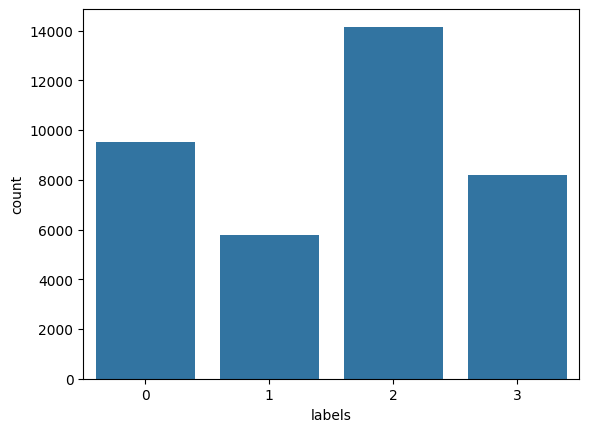

In [7]:
sns.countplot(x='labels', data=data_train)

In [8]:
data_test

,Sentences,labels
0,"Cũng qua điều này, người ta có thể hiểu rằng t...",0
1,Ông được biết đến như một người tiên phong tro...,2
2,"Vietjet bắt đầu báo cáo, thống kê và xác minh ...",1
3,SSI luôn khuyến khích và tạo điều kiện tốt nhấ...,2
4,"Triển khai và giao tiếp, cung cấp đào tạo về t...",3
...,...,...
2995,"Ngoài hỗ trợ tài chính, Quỹ Đổi mới sáng tạo V...",3
2996,Dẫn dắt một tổ chức thành công đòi hỏi sự hiểu...,0
2997,Hãy tiếp tục theo đuổi một cách tận tâm những ...,3
2998,Vicostone không ngừng phát hành các bộ sưu tập...,2


### DataLoader

In [9]:
bert_base = "./vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(bert_base, use_fast=False, local_files_only=True)
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

A word segmenter must be applied to produce word-segmented texts before feeding to PhoBERT

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df['Sentences']
        self.tokenizer = tokenizer
        self.targets = df["labels"].values.astype(int)  # đảm bảo là số nguyên
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        text = ' '.join(simple_preprocess(text))
        text = ViTokenizer.tokenize(text)
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)  # sửa từ float -> long
        }


### **Find Max Length**

**BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length.**

[]

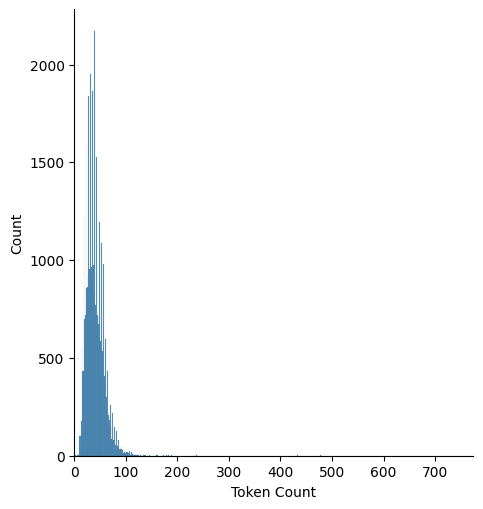

In [11]:
# Distribution of length of Sentence
all_data = data_train["Sentences"]
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')
plt.plot()

**=> Choose a maximum of length of 256 is safe.**

### Model

In [12]:
train_dataset = BERTDataset(data_train, tokenizer, 128)
valid_dataset = BERTDataset(data_test, tokenizer, 128)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, 
                          num_workers=4, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, 
                          num_workers=4, shuffle=False, pin_memory=True)

In [14]:
for batch_idx, data in enumerate(train_loader):
    print(f"Batch {batch_idx}")
    
    ids = data['ids']
    mask = data['mask']
    token_type_ids = data['token_type_ids']
    targets = data['targets']

    print("IDs:", ids.shape)
    print("Masks:", mask.shape)
    print("Token Type IDs:", token_type_ids.shape)
    print("Targets:", targets.shape)

    print("Sample 0 - IDs:", ids[0])
    print("Sample 0 - Targets:", targets[0])
    break


Batch 0
IDs: torch.Size([32, 128])
Masks: torch.Size([32, 128])
Token Type IDs: torch.Size([32, 128])
Targets: torch.Size([32])
Sample 0 - IDs: tensor([    0,   146,   302,  1430,    12,   276,     7,   572,    70,  2665,
         2652,    30,    61,   302,   675,     7,   675,  6892,     6,   572,
           70,  2105, 10125,  6520,   548,    67,    10,  4623,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1

In [15]:
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, num_labels, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(bert_base, local_files_only=True).to(torch.device("cuda:0"))
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(self.roberta.config.hidden_size, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, num_labels)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids, return_dict=False)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        return x 
model = ROBERTAClassifier(4)
model.to(device)


ROBERTAClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm

### Train & Eval Function

## Prepare data

In [16]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

In [17]:
EPOCHS = 5
LEARNING_RATE = 2e-5

In [18]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [19]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [20]:
data_train['labels'].unique()

array([0, 2, 1, 3])

In [21]:
print(targets.shape)  # Nên là [batch_size]


torch.Size([32])


In [22]:
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  1.438400387763977
Epoch: 0, Loss:  0.3740096688270569
Epoch: 0, Loss:  0.20990608632564545
Epoch: 1, Loss:  0.19113825261592865
Epoch: 1, Loss:  0.219577819108963
Epoch: 1, Loss:  0.05942245200276375
Epoch: 2, Loss:  0.05037606135010719
Epoch: 2, Loss:  0.046369072049856186
Epoch: 2, Loss:  0.09106702357530594
Epoch: 3, Loss:  0.027436988428235054
Epoch: 3, Loss:  0.039493627846241
Epoch: 3, Loss:  0.0802902951836586
Epoch: 4, Loss:  0.02224503830075264
Epoch: 4, Loss:  0.043263740837574005
Epoch: 4, Loss:  0.03562834858894348


In [23]:
def validation():
    model.eval()
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        for data in valid_loader:
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)

            targets = data['targets'].to(device, dtype=torch.long)

            outputs = model(ids, mask, token_type_ids)
            
            fin_targets.extend(targets.cpu().detach().numpy())
            fin_outputs.extend(outputs.cpu().detach().numpy())

    return fin_outputs, fin_targets


In [24]:
from sklearn import metrics
import numpy as np

outputs, targets = validation()

# Dự đoán lớp bằng argmax
preds = np.argmax(np.array(outputs), axis=1)
targets = np.array(targets)

# Đánh giá
accuracy = metrics.accuracy_score(targets, preds)
f1_micro = metrics.f1_score(targets, preds, average='micro')
f1_macro = metrics.f1_score(targets, preds, average='macro')
confusion = metrics.confusion_matrix(targets, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print("Confusion Matrix:\n", confusion)


Accuracy: 0.8903
F1 Score (Micro): 0.8903
F1 Score (Macro): 0.8800
Confusion Matrix:
 [[340  12  81  77]
 [  2 518  19  31]
 [  3   3 960  30]
 [ 10   8  53 853]]
